***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [88]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [89]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [90]:
columns=['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_connection_close',
 'http_header_connection_keep-alive',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_expect-ctmax-age',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_accept',
 'http_header_vary_age',
 'http_header_via_1.1',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled','Target','domain']

In [91]:
df=pd.read_csv('Modified_http.csv',usecols=columns)

df.rename(columns={'Malicious':'Target'},inplace=True)
df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]
df.drop(cookies,axis=1,inplace=True)

df=df[df['domain']!=0]

df.sort_values(by='Target',inplace=True,ascending=False)
df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (45856, 23)


In [20]:
train=df.iloc[:36684,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

In [21]:
test=df.iloc[36684:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [22]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [23]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.905353832734
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31703   150    31853
True        3322  1509     4831
__all__    35025  1659    36684

Accuracy of the model for test data is: 0.904709986917
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7933    49     7982
True         825   365     1190
__all__     8758   414     9172



Logistic Regression
Accuracy of the model for training data is: 0.884254715952
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29126  2727    31853
True        1519  3312     4831
__all__    30645  6039    36684

Accuracy of the model for test data is: 0.883994766681
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7311   671     7982
True         393   797     1190
__all__     7704  1468     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.919392650747
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29374  2479    31853
True         478  4353     4831
__all__    29852  6832    36684

Accuracy of the model for test data is: 0.909289140863
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7320   662     7982
True         170  1020     1190
__all__     7490  1682     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.894804274343
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29264  2589    31853
True        1270  3561     4831
__all__    30534  6150    36684

Accuracy of the model for test data is: 0.895442651548
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7337   645     7982
True         314   876     1190
__all__     7651  1521     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.907043942863
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29348  2505    31853
True         905  3926     4831
__all__    30253  6431    36684

Accuracy of the model for test data is: 0.905146096816
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7348   634     7982
True         236   954     1190
__all__     7584  1588     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.921055501036
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29399  2454    31853
True         442  4389     4831
__all__    29841  6843    36684

Accuracy of the model for test data is: 0.908416921064
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7315   667     7982
True         173  1017     1190
__all__     7488  1684     9172



Bagging Classifier
Accuracy of the model for training data is: 0.919474430269
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29373  2480    31853
True         474  4357     4831
__all__    29847  6837    36684

Accuracy of the model for test data is: 0.909507195813
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7329   653     7982
True         177  1013     1190
__all__     7506  1666     9172



Neural Network-1
The accuracy of the model on training data is: 0.906798604296


Predicted  False  True  __all__
Actual                         
False      29184  2669    31853
True         750  4081     4831
__all__    29934  6750    36684

The accuracy of the model on test data is: 0.905255124291


Predicted  False  True  __all__
Actual                         
False       7319   663     7982
True         206   984     1190
__all__     7525  1647     9172

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [24]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [25]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.905354,1509.0,31703.0,150.0,3322.0,0.004709,0.687642
LogisticRegression,0.884255,3312.0,29126.0,2727.0,1519.0,0.085612,0.314428
RandomForestClassifier,0.919393,4353.0,29374.0,2479.0,478.0,0.077826,0.098944
AdaBoostClassifier,0.894804,3561.0,29264.0,2589.0,1270.0,0.081280,0.262886
GradientBoostingClassifier,0.907044,3926.0,29348.0,2505.0,905.0,0.078643,0.187332
ExtraTreeClassifier,0.921056,4389.0,29399.0,2454.0,442.0,0.077041,0.091492
BaggingClassifier,0.919474,4357.0,29373.0,2480.0,474.0,0.077858,0.098116
Neural Network-1,0.906799,4081.0,29184.0,2669.0,750.0,0.083791,0.155247


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.904710,365.0,7933.0,49.0,825.0,0.006139,0.693277,0.650292,0.486511
LogisticRegression,0.883995,797.0,7311.0,671.0,393.0,0.084064,0.330252,0.792842,0.536749
RandomForestClassifier,0.909289,1020.0,7320.0,662.0,170.0,0.082937,0.142857,0.887103,0.672252
AdaBoostClassifier,0.895443,876.0,7337.0,645.0,314.0,0.080807,0.263866,0.827664,0.592058
GradientBoostingClassifier,0.905146,954.0,7348.0,634.0,236.0,0.079429,0.198319,0.861126,0.641422
ExtraTreeClassifier,0.908417,1017.0,7315.0,667.0,173.0,0.083563,0.145378,0.885529,0.669211
BaggingClassifier,0.909507,1013.0,7329.0,653.0,177.0,0.081809,0.148739,0.884726,0.670608
Neural Network-1,0.905255,984.0,7319.0,663.0,206.0,0.083062,0.173109,0.884726,0.651182


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [31]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

In [32]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [34]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.911876432361
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28909   2944    31853
True        2670  29183    31853
__all__    31579  32127    63706

Accuracy of the model for test data is: 0.898822503271
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7203   779     7982
True         149  1041     1190
__all__     7352  1820     9172



Logistic Regression
Accuracy of the model for training data is: 0.867108278655
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26423   5430    31853
True        3036  28817    31853
__all__    29459  34247    63706

Accuracy of the model for test data is: 0.843109463585
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6669  1313     7982
True         126  1064     1190
__all__     6795  2377     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.932612312812
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28509   3344    31853
True         949  30904    31853
__all__    29458  34248    63706

Accuracy of the model for test data is: 0.887047535979
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7051   931     7982
True         105  1085     1190
__all__     7156  2016     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.873732458481
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26814   5039    31853
True        3005  28848    31853
__all__    29819  33887    63706

Accuracy of the model for test data is: 0.849978194505
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6743  1239     7982
True         137  1053     1190
__all__     6880  2292     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.89526889147
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27919   3934    31853
True        2738  29115    31853
__all__    30657  33049    63706

Accuracy of the model for test data is: 0.879851722634
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7004   978     7982
True         124  1066     1190
__all__     7128  2044     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.935061061752
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28552   3301    31853
True         836  31017    31853
__all__    29388  34318    63706

Accuracy of the model for test data is: 0.88617531618
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7039   943     7982
True         101  1089     1190
__all__     7140  2032     9172



Bagging Classifier
Accuracy of the model for training data is: 0.932722192572
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28531   3322    31853
True         964  30889    31853
__all__    29495  34211    63706

Accuracy of the model for test data is: 0.886720453554
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7048   934     7982
True         105  1085     1190
__all__     7153  2019     9172



Neural Network-1
The accuracy of the model on training data is: 0.910275327287


Predicted  False   True  __all__
Actual                          
False      27866   3987    31853
True        1729  30124    31853
__all__    29595  34111    63706

The accuracy of the model on test data is: 0.882686436982


Predicted  False  True  __all__
Actual                         
False       7009   973     7982
True         103  1087     1190
__all__     7112  2060     9172

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [35]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [36]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.911876,29183.0,28909.0,2944.0,2670.0,0.092425,0.083823
LogisticRegression,0.867108,28817.0,26423.0,5430.0,3036.0,0.170471,0.095313
RandomForestClassifier,0.932612,30904.0,28509.0,3344.0,949.0,0.104982,0.029793
AdaBoostClassifier,0.873732,28848.0,26814.0,5039.0,3005.0,0.158195,0.094340
GradientBoostingClassifier,0.895269,29115.0,27919.0,3934.0,2738.0,0.123505,0.085957
ExtraTreeClassifier,0.935061,31017.0,28552.0,3301.0,836.0,0.103632,0.026246
BaggingClassifier,0.932722,30889.0,28531.0,3322.0,964.0,0.104292,0.030264
Neural Network-1,0.910275,30124.0,27866.0,3987.0,1729.0,0.125169,0.054281


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.898823,1041.0,7203.0,779.0,149.0,0.097595,0.125210,0.888598,0.654819
LogisticRegression,0.843109,1064.0,6669.0,1313.0,126.0,0.164495,0.105882,0.864811,0.559523
RandomForestClassifier,0.887048,1085.0,7051.0,931.0,105.0,0.116637,0.088235,0.897564,0.645187
AdaBoostClassifier,0.849978,1053.0,6743.0,1239.0,137.0,0.155224,0.115126,0.864825,0.566294
GradientBoostingClassifier,0.879852,1066.0,7004.0,978.0,124.0,0.122526,0.104202,0.886636,0.624364
ExtraTreeClassifier,0.886175,1089.0,7039.0,943.0,101.0,0.118141,0.084874,0.898493,0.644865
BaggingClassifier,0.886720,1085.0,7048.0,934.0,105.0,0.117013,0.088235,0.897376,0.644538
Neural Network-1,0.882686,1087.0,7009.0,973.0,103.0,0.121899,0.086555,0.897376,0.637347


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [37]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [42]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns[:-2]]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9662, 22)


In [43]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [45]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.897847236597
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4371   460     4831
True         527  4304     4831
__all__     4898  4764     9662

Accuracy of the model for test data is: 0.889446140427
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7117   865     7982
True         149  1041     1190
__all__     7266  1906     9172



Logistic Regression
Accuracy of the model for training data is: 0.864831297868
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4028   803     4831
True         503  4328     4831
__all__     4531  5131     9662

Accuracy of the model for test data is: 0.842019188836
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6667  1315     7982
True         134  1056     1190
__all__     6801  2371     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.929517698199
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4341   490     4831
True         191  4640     4831
__all__     4532  5130     9662

Accuracy of the model for test data is: 0.874618403838
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6929  1053     7982
True          97  1093     1190
__all__     7026  2146     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.871765679983
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4076   755     4831
True         484  4347     4831
__all__     4560  5102     9662

Accuracy of the model for test data is: 0.846380287833
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6710  1272     7982
True         137  1053     1190
__all__     6847  2325     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.891326847444
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4249   582     4831
True         468  4363     4831
__all__     4717  4945     9662

Accuracy of the model for test data is: 0.874945486263
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6957  1025     7982
True         122  1068     1190
__all__     7079  2093     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.933243634858
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4362   469     4831
True         176  4655     4831
__all__     4538  5124     9662

Accuracy of the model for test data is: 0.874073266463
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6915  1067     7982
True          88  1102     1190
__all__     7003  2169     9172



Bagging Classifier
Accuracy of the model for training data is: 0.930138687642
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4321   510     4831
True         165  4666     4831
__all__     4486  5176     9662

Accuracy of the model for test data is: 0.865787178369
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6845  1137     7982
True          94  1096     1190
__all__     6939  2233     9172



Neural Network-1
The accuracy of the model on training data is: 0.908197060564


Predicted  False  True  __all__
Actual                         
False       4291   540     4831
True         347  4484     4831
__all__     4638  5024     9662

The accuracy of the model on test data is: 0.882250327082


Predicted  False  True  __all__
Actual                         
False       7007   975     7982
True         105  1085     1190
__all__     7112  2060     9172

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [46]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [47]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.897847,4304.0,4371.0,460.0,527.0,0.095218,0.109087
LogisticRegression,0.864831,4328.0,4028.0,803.0,503.0,0.166218,0.104119
RandomForestClassifier,0.929518,4640.0,4341.0,490.0,191.0,0.101428,0.039536
AdaBoostClassifier,0.871766,4347.0,4076.0,755.0,484.0,0.156282,0.100186
GradientBoostingClassifier,0.891327,4363.0,4249.0,582.0,468.0,0.120472,0.096874
ExtraTreeClassifier,0.933244,4655.0,4362.0,469.0,176.0,0.097081,0.036431
BaggingClassifier,0.930139,4666.0,4321.0,510.0,165.0,0.105568,0.034154
Neural Network-1,0.908197,4484.0,4291.0,540.0,347.0,0.111778,0.071828


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.889446,1041.0,7117.0,865.0,149.0,0.108369,0.125210,0.883211,0.634728
LogisticRegression,0.842019,1056.0,6667.0,1315.0,134.0,0.164746,0.112605,0.861325,0.554632
RandomForestClassifier,0.874618,1093.0,6929.0,1053.0,97.0,0.131922,0.081513,0.893283,0.624303
AdaBoostClassifier,0.846380,1053.0,6710.0,1272.0,137.0,0.159359,0.115126,0.862758,0.560421
GradientBoostingClassifier,0.874945,1068.0,6957.0,1025.0,122.0,0.128414,0.102521,0.884533,0.615775
ExtraTreeClassifier,0.874073,1102.0,6915.0,1067.0,88.0,0.133676,0.073950,0.896187,0.626597
BaggingClassifier,0.865787,1096.0,6845.0,1137.0,94.0,0.142446,0.078992,0.889281,0.609579
Neural Network-1,0.882250,1085.0,7007.0,975.0,105.0,0.122150,0.088235,0.889281,0.635792


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [49]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [92]:
df.reset_index(inplace=True)
columns.remove('Target')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 946 features
EntitySet scattered to workers in 5.241 seconds
Elapsed: 00:05 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [93]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [94]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [95]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [96]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [97]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [98]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [99]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [100]:
columns=feature_selection_df[feature_selection_df.Total>=3]['Feature'].values

In [101]:
train=fs.iloc[:36684]
train_Y=train.Target.values
train_X=train[columns].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[36684:]
test_Y=test.Target.values
test_X=test[columns]

scaled_X_test=scaler.transform(test_X)

In [102]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



array([ 'http_header_content-language_text/html + http_header_transfer-encoding_chunked',
       'http_header_vary_age / http_header_content-length',
       'http_header_transfer-encoding_chunked + http_header_vary_accept',
       'http_header_transfer-encoding_chunked',
       'http_header_server_nginx + http_header_vary_accept',
       'http_header_server_nginx + http_header_transfer-encoding_chunked',
       'http_header_pragmano-cache + http_header_vary_accept',
       'http_header_content-language_text/html / http_header_transfer-encoding_chunked',
       'http_header_content-language_text/html / http_header_content-encoding_gzip',
       'http_header_content-language_text/html / http_header_connection_keep-alive',
       'http_header_content-language_text/html + http_header_via_1.1',
       'http_header_content-language_text/html + http_header_vary_accept',
       'http_header_content-language_text/html + http_header_server_nginx',
       'http_header_content-language_text/html +

In [103]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [108]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.896848762403
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31508   926    32434
True        2858  1392     4250
__all__    34366  2318    36684

Accuracy of the model for test data is: 0.826646314871
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7222   179     7401
True        1411   360     1771
__all__     8633   539     9172



Logistic Regression
Accuracy of the model for training data is: 0.898893250463
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32327   107    32434
True        3602   648     4250
__all__    35929   755    36684

Accuracy of the model for test data is: 0.816288704754
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7381    20     7401
True        1665   106     1771
__all__     9046   126     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.90489041544
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31922   512    32434
True        2977  1273     4250
__all__    34899  1785    36684

Accuracy of the model for test data is: 0.827627562146
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7304    97     7401
True        1484   287     1771
__all__     8788   384     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.889488605387
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32368    66    32434
True        3988   262     4250
__all__    36356   328    36684

Accuracy of the model for test data is: 0.810619276058
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7391    10     7401
True        1727    44     1771
__all__     9118    54     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.903064006106
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31887   547    32434
True        3009  1241     4250
__all__    34896  1788    36684

Accuracy of the model for test data is: 0.825665067597
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7295   106     7401
True        1493   278     1771
__all__     8788   384     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.905108494166
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31925   509    32434
True        2972  1278     4250
__all__    34897  1787    36684

Accuracy of the model for test data is: 0.827627562146
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7304    97     7401
True        1484   287     1771
__all__     8788   384     9172



Bagging Classifier
Accuracy of the model for training data is: 0.904999454803
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31924   510    32434
True        2975  1275     4250
__all__    34899  1785    36684

Accuracy of the model for test data is: 0.827518534671
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7303    98     7401
True        1484   287     1771
__all__     8787   385     9172



Neural Network-1
The accuracy of the model on training data is: 0.904508777662


Predicted  False  True  __all__
Actual                         
False      31920   514    32434
True        2989  1261     4250
__all__    34909  1775    36684

The accuracy of the model on test data is: 0.827736589621


Predicted  False  True  __all__
Actual                         
False       7305    96     7401
True        1484   287     1771
__all__     8789   383     9172

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [109]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [110]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.896849,1392.0,31508.0,926.0,2858.0,0.028550,0.672471
LogisticRegression,0.898893,648.0,32327.0,107.0,3602.0,0.003299,0.847529
RandomForestClassifier,0.904890,1273.0,31922.0,512.0,2977.0,0.015786,0.700471
AdaBoostClassifier,0.889489,262.0,32368.0,66.0,3988.0,0.002035,0.938353
GradientBoostingClassifier,0.903064,1241.0,31887.0,547.0,3009.0,0.016865,0.708000
ExtraTreeClassifier,0.905108,1278.0,31925.0,509.0,2972.0,0.015693,0.699294
BaggingClassifier,0.904999,1275.0,31924.0,510.0,2975.0,0.015724,0.700000
Neural Network-1,0.904509,1261.0,31920.0,514.0,2989.0,0.015848,0.703294


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.826646,360.0,7222.0,179.0,1411.0,0.024186,0.796725,0.589545,0.300572
LogisticRegression,0.816289,106.0,7381.0,20.0,1665.0,0.002702,0.940147,0.528575,0.193804
RandomForestClassifier,0.827628,287.0,7304.0,97.0,1484.0,0.013106,0.837945,0.574474,0.293550
AdaBoostClassifier,0.810619,44.0,7391.0,10.0,1727.0,0.001351,0.975155,0.511747,0.121215
GradientBoostingClassifier,0.825665,278.0,7295.0,106.0,1493.0,0.014322,0.843027,0.571326,0.281138
ExtraTreeClassifier,0.827628,287.0,7304.0,97.0,1484.0,0.013106,0.837945,0.574474,0.293550
BaggingClassifier,0.827519,287.0,7303.0,98.0,1484.0,0.013241,0.837945,0.574407,0.292919
Neural Network-1,0.827737,287.0,7305.0,96.0,1484.0,0.012971,0.837945,0.574407,0.294182


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [111]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [112]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

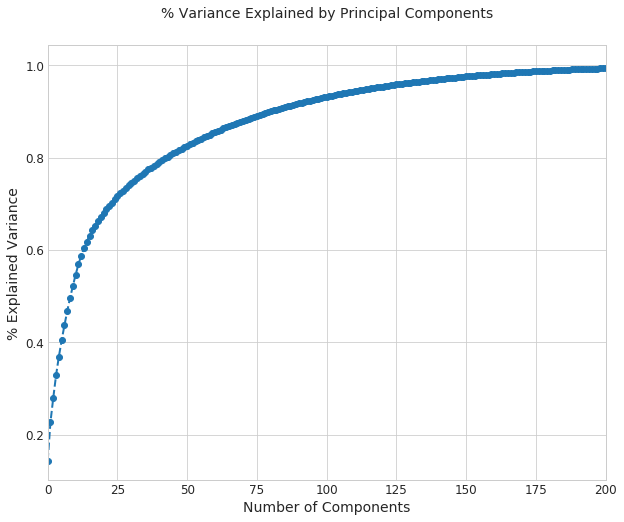

In [115]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [116]:
pca=PCA(n_components=117,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 117 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 117 components is: 0.94951751129


In [122]:
X_train=X_pca_21[:36684]
Y_train=fs.iloc[:36684]['Target'].values
X_test=X_pca_21[36684:]
Y_test=fs.iloc[36684:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [124]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,117).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.919992367245
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32313   121    32434
True        2814  1436     4250
__all__    35127  1557    36684

Accuracy of the model for test data is: 0.835368512865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7366    35     7401
True        1475   296     1771
__all__     8841   331     9172



Logistic Regression
Accuracy of the model for training data is: 0.911514556755
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32148   286    32434
True        2960  1290     4250
__all__    35108  1576    36684

Accuracy of the model for test data is: 0.831661578718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7348    53     7401
True        1491   280     1771
__all__     8839   333     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.924572020499
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32365    69    32434
True        2698  1552     4250
__all__    35063  1621    36684

Accuracy of the model for test data is: 0.836458787614
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7366    35     7401
True        1465   306     1771
__all__     8831   341     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.916257769055
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32300   134    32434
True        2938  1312     4250
__all__    35238  1446    36684

Accuracy of the model for test data is: 0.830789358918
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7369    32     7401
True        1520   251     1771
__all__     8889   283     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.920046886926
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32362    72    32434
True        2861  1389     4250
__all__    35223  1461    36684

Accuracy of the model for test data is: 0.831770606193
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7371    30     7401
True        1513   258     1771
__all__     8884   288     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.92596227238
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32372    62    32434
True        2654  1596     4250
__all__    35026  1658    36684

Accuracy of the model for test data is: 0.83591365024
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7354    47     7401
True        1458   313     1771
__all__     8812   360     9172



Bagging Classifier
Accuracy of the model for training data is: 0.924790099226
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      32366    68    32434
True        2691  1559     4250
__all__    35057  1627    36684

Accuracy of the model for test data is: 0.83525948539
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7362    39     7401
True        1472   299     1771
__all__     8834   338     9172



Neural Network-1
The accuracy of the model on training data is: 0.916639406826


Predicted  False  True  __all__
Actual                         
False      29903  2531    32434
True         527  3723     4250
__all__    30430  6254    36684

The accuracy of the model on test data is: 0.869821194941


Predicted  False  True  __all__
Actual                         
False       6842   559     7401
True         635  1136     1771
__all__     7477  1695     9172

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [125]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [126]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.919992,1436.0,32313.0,121.0,2814.0,0.003731,0.662118
LogisticRegression,0.911515,1290.0,32148.0,286.0,2960.0,0.008818,0.696471
RandomForestClassifier,0.924572,1552.0,32365.0,69.0,2698.0,0.002127,0.634824
AdaBoostClassifier,0.916258,1312.0,32300.0,134.0,2938.0,0.004131,0.691294
GradientBoostingClassifier,0.920047,1389.0,32362.0,72.0,2861.0,0.002220,0.673176
ExtraTreeClassifier,0.925962,1596.0,32372.0,62.0,2654.0,0.001912,0.624471
BaggingClassifier,0.924790,1559.0,32366.0,68.0,2691.0,0.002097,0.633176
Neural Network-1,0.916639,3723.0,29903.0,2531.0,527.0,0.078035,0.124000


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.835369,296.0,7366.0,35.0,1475.0,0.004729,0.832863,0.581204,0.343714
LogisticRegression,0.831662,280.0,7348.0,53.0,1491.0,0.007161,0.841897,0.575471,0.318522
RandomForestClassifier,0.836459,306.0,7366.0,35.0,1465.0,0.004729,0.827216,0.584027,0.350609
AdaBoostClassifier,0.830789,251.0,7369.0,32.0,1520.0,0.004324,0.858272,0.568702,0.313642
GradientBoostingClassifier,0.831771,258.0,7371.0,30.0,1513.0,0.004054,0.854320,0.570813,0.320553
ExtraTreeClassifier,0.835914,313.0,7354.0,47.0,1458.0,0.006350,0.823264,0.585193,0.346337
BaggingClassifier,0.835259,299.0,7362.0,39.0,1472.0,0.005270,0.831169,0.581781,0.342688
Neural Network-1,0.869821,1136.0,6842.0,559.0,635.0,0.075530,0.358554,0.581781,0.575516


In [3]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')